## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №28

#### Оценить возраст человека по изображению. 

#### Часть 2. Вариант решения задачи как задачи классификации

В качестве датасета взят датасет лиц по ссылке 
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

In [1]:
import math
import numpy as np
import pandas as pd

import cv2
import dlib
from PIL import Image
from imutils import face_utils
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score

RANDOM_STATE = 42

print('Cuda version: ' + tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('OpenCV version ' + cv2.__version__)

Cuda version: 2.10.1
Num GPUs Available:  1
OpenCV version 4.7.0


Загружаем описание набора данных

In [2]:
df = pd.read_csv('imdb_crops.csv')
df.head(5)

,Unnamed: 0,file_path,label
0,0,wiki_crop\cropped\10049200_1891-09-16_1958.jpg,67
1,1,wiki_crop\cropped\10110600_1985-09-17_2012.jpg,27
2,2,wiki_crop\cropped\1013900_1917-10-15_1960.jpg,43
3,3,wiki_crop\cropped\10166400_1960-03-12_2008.jpg,48
4,4,wiki_crop\cropped\10292500_1984-03-26_2009.jpg,25


Проверим распределение изображений по меткам предполагаемого возраста

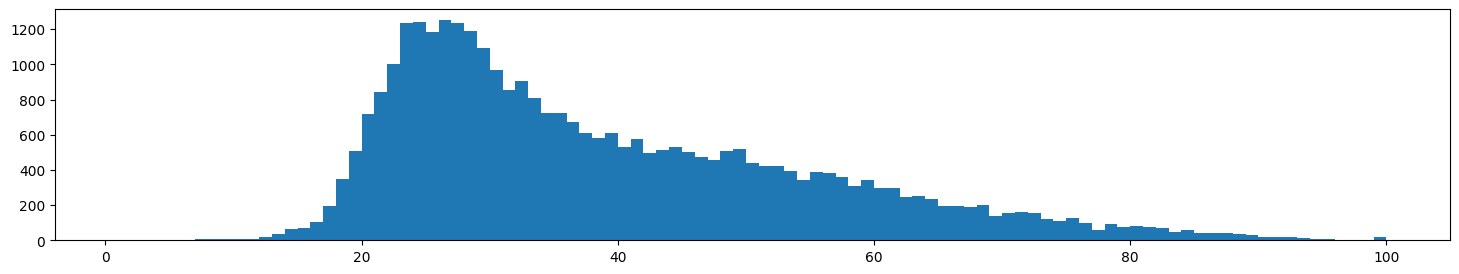

In [3]:
plt.figure(figsize=(18,3))
plt.hist(df.label, bins = df.label.nunique())
plt.show()

Выполним секвестр классов согласно предложенной возрастной классификации  

In [4]:
AGE_CATS = [
    #'(0-3)','(4-6)',
    '(1-12)','(13-20)','(21-27)','(28-33)','(34-45)','(46-59)','(60-79)','(80++)'
    ]

#df.loc[(df.label > 0) & (df.label <= 3) , 'label'] = 0 
#df.loc[(df.label > 3) & (df.label <= 6) , 'label'] = 1 
df.loc[(df.label > 0) & (df.label <= 12) , 'label'] = 0 
df.loc[(df.label > 12) & (df.label <= 20) , 'label'] = 1
df.loc[(df.label > 20) & (df.label <= 27) , 'label'] = 2
df.loc[(df.label > 27) & (df.label <= 33) , 'label'] = 3
df.loc[(df.label > 33) & (df.label <= 45) , 'label'] = 4
df.loc[(df.label > 45) & (df.label <= 59) , 'label'] = 5
df.loc[(df.label > 59) & (df.label <= 79) , 'label'] = 6
df.loc[(df.label > 79), 'label'] = 7   

df.label.value_counts()

2    7993
4    7084
3    5821
5    5754
6    3401
1    2041
7     622
0      71
Name: label, dtype: int64

1. Сформируем из изображений набор данных, как набор массивов евклидовых расстояний между точками признаков лица

In [5]:
face_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

X = []
labels = []

# Расчет евкидова расстояния между двумя точками
def calc_euclidean(a, b):
    return math.sqrt(math.pow((b[0] - a[0]), 2) + math.pow((b[1] - a[1]), 2))

# Расчет евкидовых расстояний между всеми заданными точками
def calc_euclidean_all(l):
    distances = np.zeros((68,68))
    for i in range(0, len(l)):
        for j in range(0, len(l)):
            distances[i][j] = calc_euclidean(l[i], l[j])
    return distances

# Загрузка изображений и формирования набора признаков
for index, row in tqdm(df.iterrows()):
    
    img = np.array(Image.open(row.file_path))

    w, h = img.shape[:2]
    landmarks = face_predictor(img, dlib.rectangle(0,0,w,h))

    # Сформировать признаки изображения как массив 68x68 евклидовых расстояние между всеми метками (landmarks) изображения 
    distances = calc_euclidean_all(face_utils.shape_to_np(landmarks))
    X.append(distances)

    labels.append(row.label)

X = np.asarray(X)
labels = np.asarray(labels)

print(f'Загружен массив изображений\n {X.shape}')

32787it [04:38, 117.90it/s]


Загружен массив изображений
 (32787, 68, 68)


Конвертируем целевые метки классов в разряженный массив (One-hot)

In [6]:
num_classes = len(np.unique(labels))

y = to_categorical(labels, num_classes=num_classes)

print(f'Разряженный массив целевых меток\n {y.shape}')

Разряженный массив целевых меток
 (32787, 8)


Подготовим обучающий и тестовые наборы данных

In [7]:
# Перемешаем случайным образом исходные массивы изображений и меток
indices = np.arange(X.shape[0])

np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Выполним разбиение масивов на обучающий и тестовый наборы
train_length = int(X.shape[0] * 0.7)
X_train, X_test = X[:train_length], X[train_length:]
y_train, y_test = y[:train_length], y[train_length:]

Проверим распределение изображений по классам

In [8]:
y_classes = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_classes), y=y_classes)
class_weights = dict(enumerate(class_weights))

# Веса классов
class_weights

{0: 56.25,
 1: 2.0608836206896552,
 2: 0.5149434571890146,
 3: 0.7062407680945347,
 4: 0.5686323092170465,
 5: 0.7130872483221476,
 6: 1.2150571791613722,
 7: 6.446629213483146}

Классы сильно не сбалансированы :(

Построим и выполним обучение плотной нейронной сети

In [19]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[68, 68]),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(4096, kernel_initializer='he_normal', activation='ReLU'),
    #keras.layers.BatchNormalization(),
    #keras.layers.Activation('ReLU'),
    #keras.layers.Dropout(0.2),
    
    keras.layers.Dense(num_classes, activation='softmax')
])

model1.compile(loss= 'categorical_crossentropy', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.005), 
              metrics= ['categorical_accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_categorical_accuracy',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_imdb_model1.h5',
        monitor = 'val_categorical_accuracy',
        save_Best_only=True
    )
]

print('Model summary:')
print(model1.summary())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4624)              0         
                                                                 
 batch_normalization (BatchN  (None, 4624)             18496     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              18944000  
                                                                 
 dense_1 (Dense)             (None, 8)                 32776     
                                                                 
Total params: 18,995,272
Trainable params: 18,986,024
Non-trainable params: 9,248
_________________________________________________________________
None


In [20]:
#with tf.device('/cpu:0'):
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, batch_size=1024, epochs=100,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)

print('\nModel history:')
print(history1.history.keys())

Epoch 1/100
18/18 [==============================] - 2s 99ms/step - loss: 76.0453 - categorical_accuracy: 0.2019 - val_loss: 390.8867 - val_categorical_accuracy: 0.1736 - lr: 0.0050
Epoch 2/100
18/18 [==============================] - 1s 84ms/step - loss: 11.7866 - categorical_accuracy: 0.2406 - val_loss: 48.1036 - val_categorical_accuracy: 0.2168 - lr: 0.0050
Epoch 3/100
18/18 [==============================] - 1s 83ms/step - loss: 2.0574 - categorical_accuracy: 0.3037 - val_loss: 13.4151 - val_categorical_accuracy: 0.2473 - lr: 0.0050
Epoch 4/100
18/18 [==============================] - 1s 83ms/step - loss: 3.0738 - categorical_accuracy: 0.3074 - val_loss: 24.3635 - val_categorical_accuracy: 0.2168 - lr: 0.0050
Epoch 5/100
18/18 [==============================] - 1s 84ms/step - loss: 1.7590 - categorical_accuracy: 0.3259 - val_loss: 6.8741 - val_categorical_accuracy: 0.2510 - lr: 0.0050
Epoch 6/100
18/18 [==============================] - 1s 84ms/step - loss: 1.6163 - categorical_acc

In [21]:
scores1 = model1.evaluate(X_test, y_test, verbose=0)

print("Точность на тестовых данных: %.2f%%" % (scores1[1]*100))

Точность на тестовых данных: 50.22%


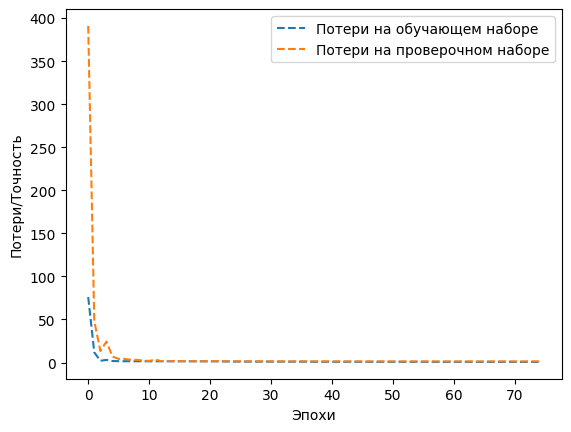

In [22]:
plt.plot(history1.history['loss'], linestyle = '--', label='Потери на обучающем наборе')
plt.plot(history1.history['val_loss'], linestyle = '--', label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

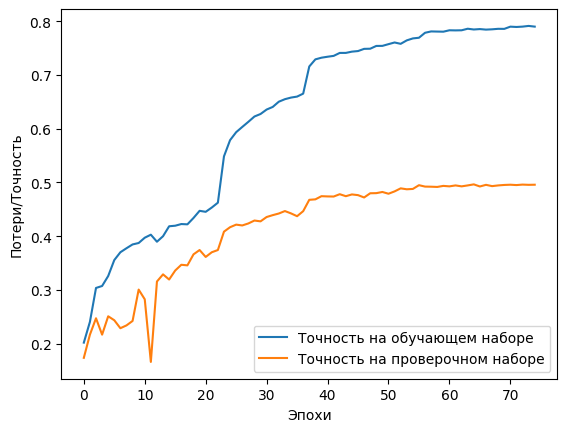

In [23]:
plt.plot(history1.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history1.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

Вариант 2. Сформируем из изображений набор данных, как набор массивов монохромных изображений, приведенных к единому разрешению

In [24]:
X = []
labels = []

# Загрузка изображений и формирования набора признаков
for index, row in tqdm(df.iterrows()):
    
    img = np.asarray(Image.open(row.file_path))
    
    blob = cv2.dnn.blobFromImage(img, scalefactor=1/255, size=(64, 64))
    X.append(np.asarray(blob[0][0]))

    labels.append(row.label)

X = np.asarray(X)
labels = np.asarray(labels)

print(f'Загружен массив изображений\n {X.shape}')

32787it [00:12, 2636.70it/s]


Загружен массив изображений
 (32787, 64, 64)


In [25]:
# Конвертируем целевые метки классов в разряженный массив (One-hot)
num_classes = len(np.unique(labels))
y = to_categorical(labels, num_classes=num_classes)

# Перемешаем случайным образом исходные массивы изображений и меток
indices = np.arange(X.shape[0])

np.random.seed(RANDOM_STATE)
np.random.shuffle(indices)
X, y = X[indices], y[indices]

# Выполним нормализацию значений
#X = X / 255.0

# Выполним разбиение масивов на обучающий и тестовый наборы
train_length = int(X.shape[0] * 0.7)
X_train, X_test = X[:train_length], X[train_length:]
y_train, y_test = y[:train_length], y[train_length:]

Проверим один из элементов получившихся наборов данных

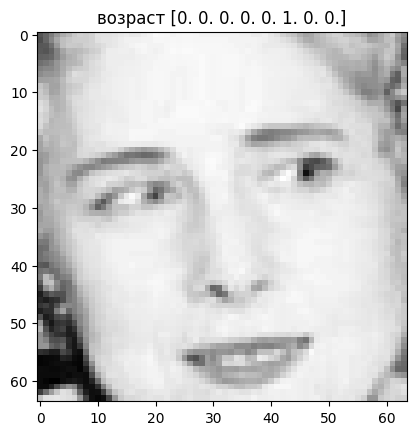

In [26]:
plt.imshow(X_train[0], cmap='gray')
plt.title(f'возраст {y_train[0]}');

Построим модель на базе плотной нейронной сети

In [27]:
keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[64, 64]),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(4096, kernel_initializer='he_normal', activation='ReLU'),
    #keras.layers.BatchNormalization(),
    #keras.layers.Activation('ReLU'),
    #keras.layers.Dropout(0.2),
    
    keras.layers.Dense(num_classes, activation='softmax')
])

model2.compile(loss= 'categorical_crossentropy', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.01), 
              metrics= ['categorical_accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_categorical_accuracy',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_imdb_model2.h5',
        monitor = 'val_categorical_accuracy',
        save_Best_only=True
    )
]

print('Model summary:')
print(model2.summary())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              16781312  
                                                                 
 dense_1 (Dense)             (None, 8)                 32776     
                                                                 
Total params: 16,830,472
Trainable params: 16,822,280
Non-trainable params: 8,192
_________________________________________________________________
None


In [28]:
with tf.device('/gpu:0'):
    history2 = model2.fit(X_train, y_train, batch_size=1024, epochs=100,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)
    
print('\nModel history:')
print(history2.history.keys())

Epoch 1/100
18/18 [==============================] - 2s 86ms/step - loss: 192.6102 - categorical_accuracy: 0.1942 - val_loss: 136.3061 - val_categorical_accuracy: 0.1730 - lr: 0.0100
Epoch 2/100
18/18 [==============================] - 1s 74ms/step - loss: 56.8050 - categorical_accuracy: 0.2007 - val_loss: 12.7178 - val_categorical_accuracy: 0.2148 - lr: 0.0100
Epoch 3/100
18/18 [==============================] - 1s 73ms/step - loss: 10.5408 - categorical_accuracy: 0.2470 - val_loss: 2.0139 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 4/100
18/18 [==============================] - 1s 74ms/step - loss: 1.7373 - categorical_accuracy: 0.3255 - val_loss: 1.8543 - val_categorical_accuracy: 0.2804 - lr: 0.0100
Epoch 5/100
18/18 [==============================] - 1s 76ms/step - loss: 1.6168 - categorical_accuracy: 0.3511 - val_loss: 1.7829 - val_categorical_accuracy: 0.2885 - lr: 0.0100
Epoch 6/100
18/18 [==============================] - 1s 74ms/step - loss: 1.5614 - categorical_acc

In [29]:
scores2 = model2.evaluate(X_test, y_test, verbose=0)

print("Точность на тестовых данных: %.2f%%" % (scores2[1]*100))

Точность на тестовых данных: 56.57%


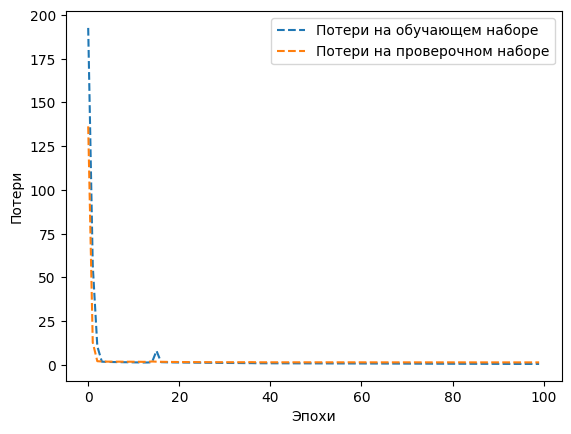

In [30]:
plt.plot(history2.history['loss'], linestyle = '--', label='Потери на обучающем наборе')
plt.plot(history2.history['val_loss'], linestyle = '--', label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

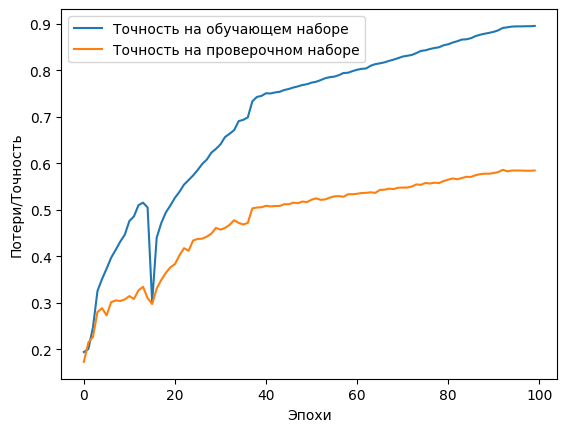

In [31]:
plt.plot(history2.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history2.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

Построим модель на базе сверточной нейронной сети

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

K = 16
N = 1024

model3 = keras.models.Sequential([
    keras.layers.Conv2D(K, (3,3), padding='SAME', kernel_initializer='he_normal', activation='ReLU', input_shape=(64, 64, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
  
    keras.layers.Conv2D(K*2, (3,3), padding='SAME', kernel_initializer='he_normal', activation='ReLU'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Conv2D(K*4, (3,3), padding='SAME', kernel_initializer='he_normal', activation='ReLU'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2,2),
    
    keras.layers.Flatten(),

    keras.layers.Dense(N, kernel_initializer='he_normal', activation='ReLU'),
    #keras.layers.Dropout(0.5),

    keras.layers.Dense(num_classes, activation='softmax')
])

model3.compile(loss= 'categorical_crossentropy', 
              optimizer=keras.optimizers.Nadam(learning_rate=0.01), 
              metrics= ['categorical_accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_categorical_accuracy',
        min_delta=1e-4,
        patience=10,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        #monitor='val_categorical_accuracy',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'keras_imdb_model3.h5',
        monitor = 'val_categorical_accuracy',
        save_Best_only=True
    )
]

print('Model summary:')
print(model3.summary())

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                         

In [36]:
with tf.device('/gpu:0'):
    history3 = model3.fit(X_train, y_train, batch_size=512, epochs=100,
                        callbacks=callbacks, 
                        validation_split=0.2, 
                        #class_weight = class_weights,
                        verbose=1)
    
print('\nModel history:')
print(history3.history.keys())

Epoch 1/100
36/36 [==============================] - 4s 73ms/step - loss: 19.1962 - categorical_accuracy: 0.2178 - val_loss: 20.3123 - val_categorical_accuracy: 0.1730 - lr: 0.0100
Epoch 2/100
36/36 [==============================] - 2s 53ms/step - loss: 1.7222 - categorical_accuracy: 0.2783 - val_loss: 10.8831 - val_categorical_accuracy: 0.1547 - lr: 0.0100
Epoch 3/100
36/36 [==============================] - 2s 53ms/step - loss: 1.6695 - categorical_accuracy: 0.3103 - val_loss: 7.1028 - val_categorical_accuracy: 0.1869 - lr: 0.0100
Epoch 4/100
36/36 [==============================] - 2s 53ms/step - loss: 1.6221 - categorical_accuracy: 0.3296 - val_loss: 6.1968 - val_categorical_accuracy: 0.2222 - lr: 0.0100
Epoch 5/100
36/36 [==============================] - 2s 53ms/step - loss: 1.6236 - categorical_accuracy: 0.3309 - val_loss: 4.6522 - val_categorical_accuracy: 0.2451 - lr: 0.0100
Epoch 6/100
36/36 [==============================] - 2s 53ms/step - loss: 1.5704 - categorical_accurac

In [37]:
scores3 = model3.evaluate(X_test, y_test, verbose=0)

print("Точность на тестовых данных: %.2f%%" % (scores3[1]*100))

Точность на тестовых данных: 50.76%


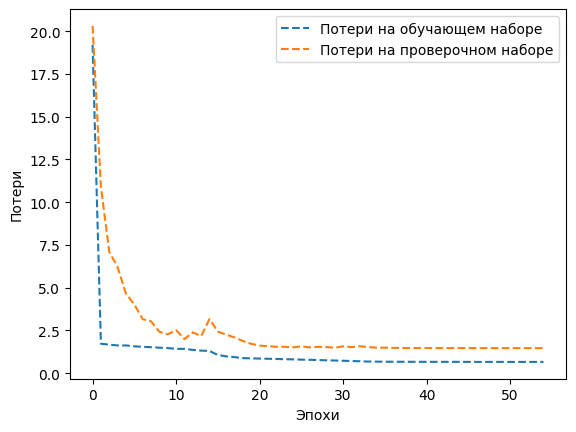

In [38]:
plt.plot(history3.history['loss'], linestyle = '--', label='Потери на обучающем наборе')
plt.plot(history3.history['val_loss'], linestyle = '--', label='Потери на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()
plt.show()

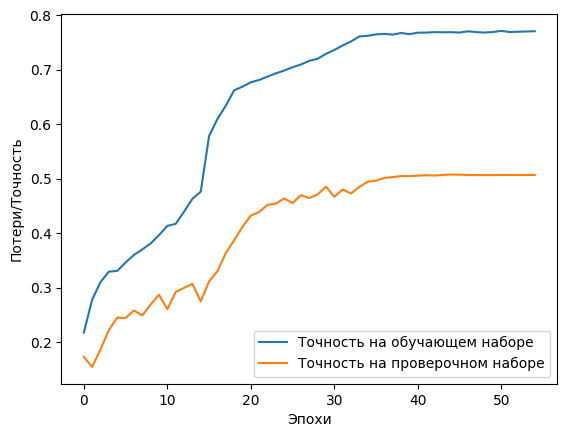

In [39]:
plt.plot(history3.history['categorical_accuracy'], label='Точность на обучающем наборе')
plt.plot(history3.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
plt.xlabel('Эпохи')
plt.ylabel('Потери/Точность')
plt.legend()
plt.show()

Сравним метрики всех обученных моделей

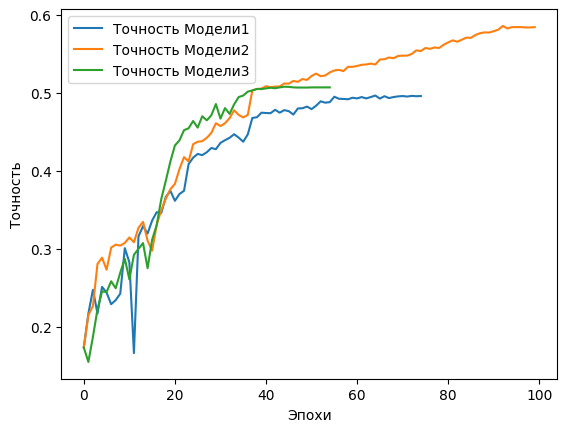

In [40]:
plt.plot(history1.history['val_categorical_accuracy'], label='Точность Модели1')
plt.plot(history2.history['val_categorical_accuracy'], label='Точность Модели2')
plt.plot(history3.history['val_categorical_accuracy'], label='Точность Модели3')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()
plt.show()